In [1]:
#Basic imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
# Import data
df = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)

In [3]:
def clean_data2(df):
    X = df.copy()
    # Remove columns with only zeros
    X = X.loc[:, (X != 0).any(axis=0)]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace nan values by mean of column
    X = X.fillna(X.mean())
                 
    # Replace Sex labels by values
    X['Sex'].replace({0:'Male', 1:'Female'}, inplace=True)
    
    # Remove useless columns
    X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Split Sex in Sex_Female and Sex_Male
    X = pd.get_dummies(X)
    
    return X

In [4]:
def scale_data(df):
    X = df.copy()
    # Categorical values
    cater = X[['Sex_Female', 'Sex_Male']]
    # Numerical values
    numer = X.drop(['Sex_Female', 'Sex_Male'], axis=1)
    #Initialize our scaler
    scaler = StandardScaler()
    #Scale each column in numer
    numer = pd.DataFrame(scaler.fit_transform(numer), columns=numer.columns)
    
    X_scaled = pd.concat([numer, cater], axis=1, join='inner')
    return X_scaled

In [5]:
X = clean_data2(df)
X_scaled = scale_data(X)

/var/folders/nb/xkb6gsv52xq9t6plg99f32v80000gn/T/ipykernel_7106/1125858367.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X = X.fillna(X.mean())


In [6]:
def plot_results(y_train, y_test, predict_train, predict_test, params, model):
    pp = PdfPages(f'{model}.pdf')
    params = ", ".join("=".join([key, str(value)]) for key, value in params.items())
    
    # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_train, dtype='int'), np.array(predict_train, dtype='int'), c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_train), max(y_train))
    p2 = min(min(predict_train), min(y_train))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title(f'{model}({params})')
    plt.xlabel('Train True Age', fontsize=15)
    plt.ylabel('Train Predicted Age', fontsize=15)
    plt.axis('equal')
    pp.savefig(plt.gcf(), bbox_inches='tight')
    plt.show()


     # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_test, dtype='int'), np.array(predict_test, dtype='int'), c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_test), max(y_test))
    p2 = min(min(predict_test), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title(f'{model}({params})')
    plt.xlabel('Test True Age', fontsize=15)
    plt.ylabel('Test Predicted Age', fontsize=15)
    plt.axis('equal')
    pp.savefig(plt.gcf(), bbox_inches='tight')
    plt.show()
    
    pp.close()

# Elastic Net

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
x = X_scaled.drop(['Age'], axis=1)
y = X['Age']

### Grid Search - Polynomial Features

In [13]:
poly = PolynomialFeatures(1)
poly_x = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.3, random_state=42)

# Define pipeline
pipe = Pipeline(steps=[
    ('select', SelectKBest(f_regression, k=10)),
    ('elastic', ElasticNet())
])

# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Define grid
grid = {
    'select__k': [10, 50, 100, 200, 'all'],
    #'select__k': [500, 2000, 10000, 'all'],
    'elastic__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'elastic__l1_ratio': np.logspace(-4, 0, 6)
}

search_elastic = GridSearchCV(pipe, grid, cv=cv, n_jobs=1, verbose=10, scoring='neg_mean_absolute_error')
search_elastic.fit(x_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV 1/10; 1/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10
[CV 1/10; 1/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10;, score=-3.717 total time=   0.0s
[CV 2/10; 1/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10
[CV 2/10; 1/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10;, score=-3.328 total time=   0.0s
[CV 3/10; 1/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10
[CV 3/10; 1/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10;, score=-2.314 total time=   0.0s
[CV 4/10; 1/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10
[CV 4/10; 1/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10;, score=-2.353 total time=   0.0s
[CV 5/10; 1/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=10
[CV 5/10; 1/120] END elastic__alpha=0.0001

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.403e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 10/10; 2/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=50;, score=-3.858 total time=   0.0s
[CV 1/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100
[CV 1/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-6.261 total time=   0.0s
[CV 2/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100
[CV 2/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-3.773 total time=   0.0s
[CV 3/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100
[CV 3/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-3.562 total time=   0.0s
[CV 4/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100
[CV 4/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-3.245 total time=   0.0s
[CV 5/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 9/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-4.146 total time=   0.0s
[CV 10/10; 3/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100
[CV 10/10; 3/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=100;, score=-5.945 total time=   0.0s
[CV 1/10; 4/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200
[CV 1/10; 4/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200;, score=-3.231 total time=   0.0s
[CV 2/10; 4/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200
[CV 2/10; 4/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200;, score=-3.584 total time=   0.0s
[CV 3/10; 4/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200
[CV 3/10; 4/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=200;, score=-3.332 total time=   0.0s
[CV 4/10; 4/120] START elastic__alpha=0.0001, elastic__l1_ratio=

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 5/10; 5/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.717 total time=   0.0s
[CV 6/10; 5/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all
[CV 6/10; 5/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.343 total time=   0.0s
[CV 7/10; 5/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all
[CV 7/10; 5/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all;, score=-3.059 total time=   0.0s
[CV 8/10; 5/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all
[CV 8/10; 5/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.261 total time=   0.0s
[CV 9/10; 5/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all
[CV 9/10; 5/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0001, select__k=all;, score=-3.819 total time=   0.0s
[CV 10/10; 5/120] START elastic__alpha=0.0001, elastic__l1_ratio=0

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 8/10; 6/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.748 total time=   0.0s
[CV 9/10; 6/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 9/10; 6/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.140 total time=   0.0s
[CV 10/10; 6/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 10/10; 6/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-2.261 total time=   0.0s
[CV 1/10; 7/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 1/10; 7/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-4.986 total time=   0.0s
[CV 2/10; 7/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 2/10; 7/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.00063095734448

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 3/10; 8/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-3.562 total time=   0.0s
[CV 4/10; 8/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 4/10; 8/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-3.245 total time=   0.0s
[CV 5/10; 8/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 5/10; 8/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-6.273 total time=   0.0s
[CV 6/10; 8/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 6/10; 8/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-4.225 total time=   0.0s
[CV 7/10; 8/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 7/10; 8/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.00063095

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/ho

[CV 3/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.332 total time=   0.0s
[CV 4/10; 9/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 4/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.686 total time=   0.1s
[CV 5/10; 9/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 5/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.221 total time=   0.0s
[CV 6/10; 9/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 6/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.691 total time=   0.0s
[CV 7/10; 9/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 7/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.00063095

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr

[CV 10/10; 9/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-1.999 total time=   0.0s
[CV 1/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 1/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.465 total time=   0.0s
[CV 2/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 2/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.602 total time=   0.0s
[CV 3/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 3/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.718 total time=   0.0s
[CV 4/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 4/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 7/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.060 total time=   0.0s
[CV 8/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 8/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.260 total time=   0.0s
[CV 9/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 9/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.819 total time=   0.0s
[CV 10/10; 10/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 10/10; 10/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.351 total time=   0.0s
[CV 1/10; 11/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 1/10; 11/120] END elastic__alpha=0.0001, elastic__l1_ratio=

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+02, tolerance: 1.001e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 12/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-2.856 total time=   0.0s
[CV 4/10; 12/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 4/10; 12/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.725 total time=   0.0s
[CV 5/10; 12/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 5/10; 12/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-4.516 total time=   0.0s
[CV 6/10; 12/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 6/10; 12/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-5.330 total time=   0.0s
[CV 7/10; 12/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 7/10; 12/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.0039810

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 13/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.224 total time=   0.0s
[CV 7/10; 13/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 7/10; 13/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.558 total time=   0.0s
[CV 8/10; 13/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 8/10; 13/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-5.918 total time=   0.0s
[CV 9/10; 13/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 9/10; 13/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.146 total time=   0.0s
[CV 10/10; 13/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 10/10; 13/120] END elastic__alpha=0.0001, elastic__l1_ratio

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 3/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.718 total time=   0.0s
[CV 4/10; 15/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 4/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.491 total time=   0.0s
[CV 5/10; 15/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 5/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.710 total time=   0.0s
[CV 6/10; 15/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 6/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.343 total time=   0.0s
[CV 7/10; 15/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 7/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 9/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.818 total time=   0.0s
[CV 10/10; 15/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 10/10; 15/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.351 total time=   0.0s
[CV 1/10; 16/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 1/10; 16/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.717 total time=   0.0s
[CV 2/10; 16/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 2/10; 16/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.328 total time=   0.0s
[CV 3/10; 16/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 3/10; 16/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.02

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.144e+01, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 17/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-5.330 total time=   0.0s
[CV 7/10; 17/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 7/10; 17/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-4.596 total time=   0.0s
[CV 8/10; 17/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 8/10; 17/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-4.253 total time=   0.0s
[CV 9/10; 17/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 9/10; 17/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-4.364 total time=   0.0s
[CV 10/10; 17/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 10/10; 17/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.02511

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e-01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 18/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-5.919 total time=   0.0s
[CV 9/10; 18/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 9/10; 18/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-4.144 total time=   0.0s
[CV 10/10; 18/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 10/10; 18/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-5.944 total time=   0.0s
[CV 1/10; 19/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 1/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.227 total time=   0.0s
[CV 2/10; 19/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 2/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 7/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-4.058 total time=   0.0s
[CV 8/10; 19/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 8/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.835 total time=   0.0s
[CV 9/10; 19/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 9/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.451 total time=   0.0s
[CV 10/10; 19/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 10/10; 19/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-1.998 total time=   0.0s
[CV 1/10; 20/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 1/10; 20/120] END elastic__alpha=0.0001, elastic__l1_ratio

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 10/10; 20/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.349 total time=   0.0s
[CV 1/10; 21/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 1/10; 21/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.717 total time=   0.0s
[CV 2/10; 21/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 2/10; 21/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.328 total time=   0.0s
[CV 3/10; 21/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 3/10; 21/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-2.316 total time=   0.0s
[CV 4/10; 21/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 4/10; 21/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.158489319246

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 23/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-6.272 total time=   0.0s
[CV 2/10; 23/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 2/10; 23/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.779 total time=   0.0s
[CV 3/10; 23/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 3/10; 23/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.585 total time=   0.0s
[CV 4/10; 23/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 4/10; 23/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.249 total time=   0.0s
[CV 5/10; 23/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 5/10; 23/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.1584893

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.731e-01, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 1/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.208 total time=   0.0s
[CV 2/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 2/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.388 total time=   0.0s
[CV 3/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 3/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.288 total time=   0.0s
[CV 4/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 4/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.632 total time=   0.0s
[CV 5/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 5/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.1584893

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 6/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.710 total time=   0.0s
[CV 7/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 7/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-4.016 total time=   0.0s
[CV 8/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 8/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.823 total time=   0.0s
[CV 9/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 9/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.443 total time=   0.0s
[CV 10/10; 24/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 10/10; 24/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 1/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.415 total time=   0.1s
[CV 2/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 2/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.559 total time=   0.1s
[CV 3/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 3/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.711 total time=   0.0s
[CV 4/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 4/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.464 total time=   0.0s
[CV 5/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 5/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.1584893

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 6/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.338 total time=   0.0s
[CV 7/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 7/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.106 total time=   0.0s
[CV 8/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 8/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.215 total time=   0.0s
[CV 9/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 9/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.676 total time=   0.0s
[CV 10/10; 25/120] START elastic__alpha=0.0001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 10/10; 25/120] END elastic__alpha=0.0001, elastic__l1_ratio=0.15848

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff


[CV 4/10; 26/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10;, score=-2.353 total time=   0.0s
[CV 5/10; 26/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10
[CV 5/10; 26/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10;, score=-2.513 total time=   0.0s
[CV 6/10; 26/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10
[CV 6/10; 26/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10;, score=-2.872 total time=   0.0s
[CV 7/10; 26/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10
[CV 7/10; 26/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10;, score=-4.149 total time=   0.0s
[CV 8/10; 26/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10
[CV 8/10; 26/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10;, score=-3.748 total time=   0.0s
[CV 9/10; 26/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=10
[CV 9/10;

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 2/10; 28/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100;, score=-3.810 total time=   0.0s
[CV 3/10; 28/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100
[CV 3/10; 28/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100;, score=-3.684 total time=   0.0s
[CV 4/10; 28/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100
[CV 4/10; 28/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100;, score=-3.282 total time=   0.0s
[CV 5/10; 28/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100
[CV 5/10; 28/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100;, score=-6.266 total time=   0.0s
[CV 6/10; 28/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100
[CV 6/10; 28/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100;, score=-4.174 total time=   0.0s
[CV 7/10; 28/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=100


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 2/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-3.224 total time=   0.0s
[CV 3/10; 29/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200
[CV 3/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-3.068 total time=   0.0s
[CV 4/10; 29/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200
[CV 4/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-3.532 total time=   0.0s
[CV 5/10; 29/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200
[CV 5/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-3.407 total time=   0.0s
[CV 6/10; 29/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200
[CV 6/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-2.682 total time=   0.0s
[CV 7/10; 29/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 29/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=200;, score=-2.188 total time=   0.0s
[CV 1/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 1/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-3.306 total time=   0.0s
[CV 2/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 2/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.629 total time=   0.0s
[CV 3/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 3/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.500 total time=   0.0s
[CV 4/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 4/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-3.397 total time=   0.0s
[CV 5/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 5/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.491 total time=   0.1s
[CV 6/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 6/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.638 total time=   0.0s
[CV 7/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 7/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-3.454 total time=   0.0s
[CV 8/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 8/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.224 total time=   0.0s
[CV 9/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all
[CV 9/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-3.366 total time=   0.0s
[CV 10/10; 30/120] START elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 30/120] END elastic__alpha=0.0001, elastic__l1_ratio=1.0, select__k=all;, score=-2.412 total time=   0.0s
[CV 1/10; 31/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10
[CV 1/10; 31/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10;, score=-3.715 total time=   0.0s
[CV 2/10; 31/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10
[CV 2/10; 31/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10;, score=-3.327 total time=   0.0s
[CV 3/10; 31/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10
[CV 3/10; 31/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10;, score=-2.206 total time=   0.0s
[CV 4/10; 31/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10
[CV 4/10; 31/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=10;, score=-2.354 total time=   0.0s
[CV 5/10; 31/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, sel

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.443e+01, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 9/10; 32/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=50;, score=-4.271 total time=   0.0s
[CV 10/10; 32/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=50
[CV 10/10; 32/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=50;, score=-3.723 total time=   0.0s
[CV 1/10; 33/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100
[CV 1/10; 33/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100;, score=-6.456 total time=   0.0s
[CV 2/10; 33/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100
[CV 2/10; 33/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100;, score=-3.795 total time=   0.0s
[CV 3/10; 33/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100
[CV 3/10; 33/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100;, score=-3.785 total time=   0.0s
[CV 4/10; 33/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+00, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 33/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100;, score=-4.062 total time=   0.0s
[CV 10/10; 33/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100
[CV 10/10; 33/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=100;, score=-5.785 total time=   0.0s
[CV 1/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 1/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.999 total time=   0.0s
[CV 2/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 2/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.777 total time=   0.0s
[CV 3/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 3/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.409 total time=   0.0s
[CV 4/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.014 total time=   0.0s
[CV 7/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 7/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-3.573 total time=   0.0s
[CV 8/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 8/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.950 total time=   0.0s
[CV 9/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 9/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-3.208 total time=   0.0s
[CV 10/10; 34/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200
[CV 10/10; 34/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=200;, score=-2.469 total time=   0.0s
[CV 1/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.769e-01, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 2/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.387 total time=   0.0s
[CV 3/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 3/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.360 total time=   0.0s
[CV 4/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 4/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-3.254 total time=   0.0s
[CV 5/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 5/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.351 total time=   0.0s
[CV 6/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 6/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.212 total time=   0.0s
[CV 7/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.697e-01, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-3.240 total time=   0.0s
[CV 8/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 8/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.306 total time=   0.0s
[CV 9/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 9/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-3.450 total time=   0.1s
[CV 10/10; 35/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all
[CV 10/10; 35/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0001, select__k=all;, score=-2.529 total time=   0.1s
[CV 1/10; 36/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 1/10; 36/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.715 total time=   0.0s
[CV 2/10; 36/120] START elastic__alpha

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.650e-01, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 10/10; 36/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-2.264 total time=   0.0s
[CV 1/10; 37/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 1/10; 37/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-4.951 total time=   0.0s
[CV 2/10; 37/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 2/10; 37/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-4.421 total time=   0.0s
[CV 3/10; 37/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 3/10; 37/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-2.504 total time=   0.0s
[CV 4/10; 37/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 4/10; 37/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e+00, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 4/10; 38/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-3.107 total time=   0.0s
[CV 5/10; 38/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 5/10; 38/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-6.989 total time=   0.0s
[CV 6/10; 38/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 6/10; 38/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-4.018 total time=   0.0s
[CV 7/10; 38/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 7/10; 38/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-4.191 total time=   0.0s
[CV 8/10; 38/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 8/10; 38/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00063095

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e-01, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.408 total time=   0.0s
[CV 4/10; 39/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 4/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.490 total time=   0.0s
[CV 5/10; 39/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 5/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.140 total time=   0.0s
[CV 6/10; 39/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 6/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.014 total time=   0.0s
[CV 7/10; 39/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 7/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00063095

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e-01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 39/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.469 total time=   0.0s
[CV 1/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 1/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.207 total time=   0.0s
[CV 2/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 2/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.387 total time=   0.0s
[CV 3/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 3/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.360 total time=   0.0s
[CV 4/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 4/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0006309

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 5/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.350 total time=   0.0s
[CV 6/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 6/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.212 total time=   0.0s
[CV 7/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 7/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.240 total time=   0.0s
[CV 8/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 8/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.306 total time=   0.0s
[CV 9/10; 40/120] START elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 9/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00063095

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 40/120] END elastic__alpha=0.001, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.529 total time=   0.1s
[CV 1/10; 41/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 1/10; 41/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10;, score=-3.715 total time=   0.0s
[CV 2/10; 41/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 2/10; 41/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10;, score=-3.327 total time=   0.0s
[CV 3/10; 41/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 3/10; 41/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10;, score=-2.206 total time=   0.0s
[CV 4/10; 41/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 4/10; 41/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00398107170553

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.801e+01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 9/10; 42/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-4.271 total time=   0.0s
[CV 10/10; 42/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 10/10; 42/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.723 total time=   0.0s
[CV 1/10; 43/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 1/10; 43/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-6.456 total time=   0.0s
[CV 2/10; 43/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 2/10; 43/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-3.794 total time=   0.0s
[CV 3/10; 43/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 3/10; 43/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+00, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.998 total time=   0.0s
[CV 2/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 2/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.772 total time=   0.0s
[CV 3/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 3/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.402 total time=   0.0s
[CV 4/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 4/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-3.487 total time=   0.0s
[CV 5/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 5/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00398107

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e-01, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 8/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.950 total time=   0.0s
[CV 9/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 9/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-3.205 total time=   0.0s
[CV 10/10; 44/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 10/10; 44/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.470 total time=   0.0s
[CV 1/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 1/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.202 total time=   0.0s
[CV 2/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.0039

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.637e-01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.361 total time=   0.0s
[CV 4/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 4/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.251 total time=   0.0s
[CV 5/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 5/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.349 total time=   0.0s
[CV 6/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 6/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.216 total time=   0.0s
[CV 7/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 7/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.00398107

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.311 total time=   0.0s
[CV 9/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 9/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.438 total time=   0.0s
[CV 10/10; 45/120] START elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 10/10; 45/120] END elastic__alpha=0.001, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.529 total time=   0.0s
[CV 1/10; 46/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 1/10; 46/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.715 total time=   0.0s
[CV 2/10; 46/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 2/10; 46/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.537e+00, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 4/10; 47/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-3.692 total time=   0.0s
[CV 5/10; 47/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 5/10; 47/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-4.353 total time=   0.0s
[CV 6/10; 47/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 6/10; 47/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-5.029 total time=   0.0s
[CV 7/10; 47/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 7/10; 47/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50;, score=-4.426 total time=   0.0s
[CV 8/10; 47/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=50
[CV 8/10; 47/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0251188643150958

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e+00, tolerance: 1.001e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 48/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-4.010 total time=   0.0s
[CV 7/10; 48/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 7/10; 48/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-4.190 total time=   0.0s
[CV 8/10; 48/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 8/10; 48/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-5.827 total time=   0.0s
[CV 9/10; 48/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 9/10; 48/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-4.063 total time=   0.0s
[CV 10/10; 48/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 10/10; 48/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.131e-01, tolerance: 1.001e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 4/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.469 total time=   0.0s
[CV 5/10; 49/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 5/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.145 total time=   0.0s
[CV 6/10; 49/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 6/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.010 total time=   0.0s
[CV 7/10; 49/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 7/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.539 total time=   0.0s
[CV 8/10; 49/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 8/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.02511886

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.477e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 49/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.476 total time=   0.0s
[CV 1/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 1/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.163 total time=   0.0s
[CV 2/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 2/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.382 total time=   0.0s
[CV 3/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 3/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.365 total time=   0.0s
[CV 4/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 4/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.0251188

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.227 total time=   0.0s
[CV 7/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 7/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.245 total time=   0.0s
[CV 8/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 8/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.335 total time=   0.0s
[CV 9/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 9/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.379 total time=   0.0s
[CV 10/10; 50/120] START elastic__alpha=0.001, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 10/10; 50/120] END elastic__alpha=0.001, elastic__l1_ratio=0.025118

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 51/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-4.115 total time=   0.0s
[CV 8/10; 51/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 8/10; 51/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.743 total time=   0.0s
[CV 9/10; 51/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 9/10; 51/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.140 total time=   0.0s
[CV 10/10; 51/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 10/10; 51/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-2.264 total time=   0.0s
[CV 1/10; 52/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=50
[CV 1/10; 52/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, sel

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 2/10; 53/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.730 total time=   0.0s
[CV 3/10; 53/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 3/10; 53/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.758 total time=   0.0s
[CV 4/10; 53/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 4/10; 53/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.138 total time=   0.0s
[CV 5/10; 53/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 5/10; 53/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-6.931 total time=   0.0s
[CV 6/10; 53/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 6/10; 53/120] END elastic__alpha=0.001, elastic__l1_ratio=0.1584893192461114

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+00, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.081 total time=   0.0s
[CV 2/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 2/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.604 total time=   0.0s
[CV 3/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 3/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.107 total time=   0.0s
[CV 4/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 4/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.464 total time=   0.0s
[CV 5/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 5/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.1584893192461114

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.402e-01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.007 total time=   0.0s
[CV 9/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 9/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.150 total time=   0.0s
[CV 10/10; 54/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 10/10; 54/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.548 total time=   0.0s
[CV 1/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 1/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.143 total time=   0.0s
[CV 2/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 2/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e-01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 4/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.106 total time=   0.0s
[CV 5/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 5/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.518 total time=   0.0s
[CV 6/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 6/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.232 total time=   0.0s
[CV 7/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 7/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.307 total time=   0.0s
[CV 8/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 8/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.1584893192461114

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.873e-01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.042 total time=   0.1s
[CV 10/10; 55/120] START elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 10/10; 55/120] END elastic__alpha=0.001, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.574 total time=   0.0s
[CV 1/10; 56/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10
[CV 1/10; 56/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10;, score=-3.715 total time=   0.0s
[CV 2/10; 56/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10
[CV 2/10; 56/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10;, score=-3.326 total time=   0.0s
[CV 3/10; 56/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10
[CV 3/10; 56/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=10;, score=-2.211 total time=   0.0s
[CV 4/10; 56/120] START elastic__alpha=0.001, ela

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.188e+00, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 57/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=50;, score=-4.096 total time=   0.0s
[CV 9/10; 57/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=50
[CV 9/10; 57/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=50;, score=-4.281 total time=   0.0s
[CV 10/10; 57/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=50
[CV 10/10; 57/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=50;, score=-3.808 total time=   0.0s
[CV 1/10; 58/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=100
[CV 1/10; 58/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=100;, score=-6.130 total time=   0.0s
[CV 2/10; 58/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=100
[CV 2/10; 58/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=100;, score=-3.570 total time=   0.0s
[CV 3/10; 58/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=100
[CV 3/10; 58/

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e+00, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-3.473 total time=   0.0s
[CV 2/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 2/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-2.092 total time=   0.0s
[CV 3/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 3/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-2.642 total time=   0.0s
[CV 4/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 4/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-3.601 total time=   0.0s
[CV 5/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 5/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-2.880 total time=   0.0s
[CV 6/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 6/10; 

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.803e-01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-2.849 total time=   0.0s
[CV 9/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 9/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-3.381 total time=   0.0s
[CV 10/10; 59/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200
[CV 10/10; 59/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=200;, score=-2.915 total time=   0.0s
[CV 1/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 1/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-3.347 total time=   0.0s
[CV 2/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 2/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-2.277 total time=   0.1s
[CV 3/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.646e-01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-2.537 total time=   0.0s
[CV 4/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 4/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-2.936 total time=   0.0s
[CV 5/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 5/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-3.185 total time=   0.0s
[CV 6/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 6/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-2.154 total time=   0.0s
[CV 7/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 7/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-3.507 total time=   0.0s
[CV 8/10; 60/120] START elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all
[CV 8/10; 

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.884e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 60/120] END elastic__alpha=0.001, elastic__l1_ratio=1.0, select__k=all;, score=-2.637 total time=   0.0s
[CV 1/10; 61/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10
[CV 1/10; 61/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10;, score=-3.700 total time=   0.0s
[CV 2/10; 61/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10
[CV 2/10; 61/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10;, score=-3.313 total time=   0.0s
[CV 3/10; 61/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10
[CV 3/10; 61/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10;, score=-2.152 total time=   0.0s
[CV 4/10; 61/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10
[CV 4/10; 61/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10;, score=-2.360 total time=   0.0s
[CV 5/10; 61/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=10


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+00, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 1/10; 63/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100;, score=-5.726 total time=   0.0s
[CV 2/10; 63/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100
[CV 2/10; 63/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100;, score=-3.469 total time=   0.0s
[CV 3/10; 63/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100
[CV 3/10; 63/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100;, score=-3.154 total time=   0.0s
[CV 4/10; 63/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100
[CV 4/10; 63/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100;, score=-3.014 total time=   0.0s
[CV 5/10; 63/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100
[CV 5/10; 63/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=100;, score=-6.360 total time=   0.0s
[CV 6/10; 63/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, sele

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e+01, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-3.241 total time=   0.0s
[CV 2/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200
[CV 2/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.497 total time=   0.0s
[CV 3/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200
[CV 3/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.439 total time=   0.0s
[CV 4/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200
[CV 4/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.901 total time=   0.0s
[CV 5/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200
[CV 5/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.884 total time=   0.0s
[CV 6/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, sele

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e+00, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.931 total time=   0.0s
[CV 10/10; 64/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200
[CV 10/10; 64/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=200;, score=-2.584 total time=   0.0s
[CV 1/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 1/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-3.168 total time=   0.0s
[CV 2/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 2/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.369 total time=   0.0s
[CV 3/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 3/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.917 total time=   0.0s
[CV 4/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, se

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+00, tolerance: 1.001e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside


[CV 5/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 5/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.824 total time=   0.0s
[CV 6/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 6/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.592 total time=   0.0s
[CV 7/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 7/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-3.157 total time=   0.0s
[CV 8/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 8/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.505 total time=   0.1s
[CV 9/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+00, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.880 total time=   0.0s
[CV 10/10; 65/120] START elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all
[CV 10/10; 65/120] END elastic__alpha=0.01, elastic__l1_ratio=0.0001, select__k=all;, score=-2.740 total time=   0.0s
[CV 1/10; 66/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 1/10; 66/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.700 total time=   0.0s
[CV 2/10; 66/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 2/10; 66/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.313 total time=   0.0s
[CV 3/10; 66/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 3/10; 66/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-2.152 total time=   

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.716e-01, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 67/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-3.995 total time=   0.0s
[CV 8/10; 67/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 8/10; 67/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-3.308 total time=   0.0s
[CV 9/10; 67/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 9/10; 67/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-3.934 total time=   0.0s
[CV 10/10; 67/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50
[CV 10/10; 67/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=50;, score=-3.259 total time=   0.0s
[CV 1/10; 68/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 1/10; 68/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, se

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 68/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-4.142 total time=   0.0s
[CV 10/10; 68/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=100
[CV 10/10; 68/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=100;, score=-4.742 total time=   0.0s
[CV 1/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 1/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.241 total time=   0.0s
[CV 2/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 2/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.496 total time=   0.0s
[CV 3/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 3/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+00, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.291 total time=   0.0s
[CV 8/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 8/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.101 total time=   0.0s
[CV 9/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 9/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.931 total time=   0.0s
[CV 10/10; 69/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 10/10; 69/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.583 total time=   0.0s
[CV 1/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 1/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e+00, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.918 total time=   0.1s
[CV 4/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 4/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.937 total time=   0.0s
[CV 5/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 5/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.823 total time=   0.0s
[CV 6/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 6/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.591 total time=   0.0s
[CV 7/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 7/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.00063095734448019

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 8/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.505 total time=   0.0s
[CV 9/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 9/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.881 total time=   0.0s
[CV 10/10; 70/120] START elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 10/10; 70/120] END elastic__alpha=0.01, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.741 total time=   0.1s
[CV 1/10; 71/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 1/10; 71/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=10;, score=-3.700 total time=   0.0s
[CV 2/10; 71/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 2/10; 71/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 3/10; 72/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-2.073 total time=   0.0s
[CV 4/10; 72/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 4/10; 72/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.425 total time=   0.0s
[CV 5/10; 72/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 5/10; 72/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.954 total time=   0.0s
[CV 6/10; 72/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 6/10; 72/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-4.502 total time=   0.0s
[CV 7/10; 72/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 7/10; 72/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, selec

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.794e+00, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 73/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.089 total time=   0.0s
[CV 7/10; 73/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 7/10; 73/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-3.964 total time=   0.0s
[CV 8/10; 73/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 8/10; 73/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.974 total time=   0.0s
[CV 9/10; 73/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 9/10; 73/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100;, score=-4.143 total time=   0.0s
[CV 10/10; 73/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=100
[CV 10/10; 73/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+00, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.427 total time=   0.0s
[CV 4/10; 74/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 4/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.906 total time=   0.0s
[CV 5/10; 74/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 5/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.884 total time=   0.0s
[CV 6/10; 74/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 6/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.364 total time=   0.0s
[CV 7/10; 74/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 7/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.00398107170553497

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.635e+00, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.928 total time=   0.0s
[CV 10/10; 74/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 10/10; 74/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.578 total time=   0.0s
[CV 1/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 1/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.163 total time=   0.0s
[CV 2/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 2/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.367 total time=   0.0s
[CV 3/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 3/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+00, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 5/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.811 total time=   0.1s
[CV 6/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 6/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.585 total time=   0.0s
[CV 7/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 7/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.168 total time=   0.0s
[CV 8/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 8/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.507 total time=   0.0s
[CV 9/10; 75/120] START elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 9/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.00398107170553497

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+00, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 75/120] END elastic__alpha=0.01, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.747 total time=   0.0s
[CV 1/10; 76/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 1/10; 76/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.700 total time=   0.0s
[CV 2/10; 76/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 2/10; 76/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.313 total time=   0.0s
[CV 3/10; 76/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 3/10; 76/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-2.153 total time=   0.0s
[CV 4/10; 76/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 4/10; 76/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, sel

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+00, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 2/10; 78/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-3.457 total time=   0.0s
[CV 3/10; 78/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 3/10; 78/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-3.154 total time=   0.0s
[CV 4/10; 78/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 4/10; 78/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-3.010 total time=   0.0s
[CV 5/10; 78/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 5/10; 78/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-6.333 total time=   0.0s
[CV 6/10; 78/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 6/10; 78/120] END elastic__alpha=0.01, elastic__l1_ratio=0.02511886431509582

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+00, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 2/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.426 total time=   0.0s
[CV 3/10; 79/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 3/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.386 total time=   0.0s
[CV 4/10; 79/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 4/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.938 total time=   0.0s
[CV 5/10; 79/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 5/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.853 total time=   0.0s
[CV 6/10; 79/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 6/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.02511886431509582

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e+00, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.904 total time=   0.0s
[CV 10/10; 79/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 10/10; 79/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.550 total time=   0.0s
[CV 1/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 1/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.160 total time=   0.0s
[CV 2/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 2/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.332 total time=   0.0s
[CV 3/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 3/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+00, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 5/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.743 total time=   0.1s
[CV 6/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 6/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.526 total time=   0.0s
[CV 7/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 7/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.238 total time=   0.0s
[CV 8/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 8/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.532 total time=   0.0s
[CV 9/10; 80/120] START elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 9/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.02511886431509582

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e+00, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 10/10; 80/120] END elastic__alpha=0.01, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.768 total time=   0.0s
[CV 1/10; 81/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 1/10; 81/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.699 total time=   0.0s
[CV 2/10; 81/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 2/10; 81/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.311 total time=   0.0s
[CV 3/10; 81/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 3/10; 81/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-2.157 total time=   0.0s
[CV 4/10; 81/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 4/10; 81/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=1

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e-01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 4/10; 83/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.017 total time=   0.0s
[CV 5/10; 83/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 5/10; 83/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-6.263 total time=   0.0s
[CV 6/10; 83/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 6/10; 83/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-4.087 total time=   0.0s
[CV 7/10; 83/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 7/10; 83/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100;, score=-3.870 total time=   0.0s
[CV 8/10; 83/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=100
[CV 8/10; 83/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.854e-01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 3/10; 84/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.278 total time=   0.0s
[CV 4/10; 84/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 4/10; 84/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-3.151 total time=   0.0s
[CV 5/10; 84/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 5/10; 84/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.743 total time=   0.0s
[CV 6/10; 84/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 6/10; 84/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.187 total time=   0.0s
[CV 7/10; 84/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 7/10; 84/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e+00, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 1/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.145 total time=   0.0s
[CV 2/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 2/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.264 total time=   0.0s
[CV 3/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 3/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.616 total time=   0.0s
[CV 4/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 4/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.818 total time=   0.0s
[CV 5/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 5/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.024e-01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-3.365 total time=   0.0s
[CV 8/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 8/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.611 total time=   0.0s
[CV 9/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 9/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.708 total time=   0.0s
[CV 10/10; 85/120] START elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 10/10; 85/120] END elastic__alpha=0.01, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.628 total time=   0.0s
[CV 1/10; 86/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=10
[CV 1/10; 86/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=10;, score=-3.693 total tim

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the 

[CV 5/10; 87/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50;, score=-3.929 total time=   0.0s
[CV 6/10; 87/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50
[CV 6/10; 87/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50;, score=-4.589 total time=   0.0s
[CV 7/10; 87/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50
[CV 7/10; 87/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50;, score=-3.889 total time=   0.0s
[CV 8/10; 87/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50
[CV 8/10; 87/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50;, score=-3.274 total time=   0.0s
[CV 9/10; 87/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50
[CV 9/10; 87/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50;, score=-3.876 total time=   0.0s
[CV 10/10; 87/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=50
[CV 10/10; 87/120] END elasti

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.426e-01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle


[CV 10/10; 88/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=100
[CV 10/10; 88/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=100;, score=-4.554 total time=   0.0s
[CV 1/10; 89/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200
[CV 1/10; 89/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200;, score=-4.042 total time=   0.0s
[CV 2/10; 89/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200
[CV 2/10; 89/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200;, score=-2.311 total time=   0.0s
[CV 3/10; 89/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200
[CV 3/10; 89/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200;, score=-3.224 total time=   0.0s
[CV 4/10; 89/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200
[CV 4/10; 89/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=200;, score=-3.088 total time=   0.0s
[CV 5/10; 89/120]

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the 

[CV 1/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-2.555 total time=   0.1s
[CV 2/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 2/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-2.396 total time=   0.0s
[CV 3/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 3/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-3.499 total time=   0.0s
[CV 4/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 4/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-2.762 total time=   0.0s
[CV 5/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 5/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-3.820 total time=   0.0s
[CV 6/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 6/10; 90/120] EN

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-2.688 total time=   0.1s
[CV 10/10; 90/120] START elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all
[CV 10/10; 90/120] END elastic__alpha=0.01, elastic__l1_ratio=1.0, select__k=all;, score=-2.662 total time=   0.0s
[CV 1/10; 91/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10
[CV 1/10; 91/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10;, score=-3.657 total time=   0.0s
[CV 2/10; 91/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10
[CV 2/10; 91/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10;, score=-3.267 total time=   0.0s
[CV 3/10; 91/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10
[CV 3/10; 91/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10;, score=-2.177 total time=   0.0s
[CV 4/10; 91/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=10
[CV 4/10; 9

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 2/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.441 total time=   0.1s
[CV 3/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 3/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.331 total time=   0.1s
[CV 4/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 4/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.900 total time=   0.1s
[CV 5/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 5/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.549 total time=   0.1s
[CV 6/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.117e+00, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.235 total time=   0.1s
[CV 7/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 7/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-3.243 total time=   0.1s
[CV 8/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 8/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-3.001 total time=   0.1s
[CV 9/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 9/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.871 total time=   0.1s
[CV 10/10; 94/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200
[CV 10/10; 94/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=200;, score=-2.427 total time=   0.1s
[CV 1/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 1/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-3.110 total time=   0.0s
[CV 2/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 2/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.374 total time=   0.0s
[CV 3/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 3/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.615 total time=   0.0s
[CV 4/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=al

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 4/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.825 total time=   0.1s
[CV 5/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 5/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.617 total time=   0.0s
[CV 6/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 6/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.290 total time=   0.0s
[CV 7/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 7/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-3.112 total time=   0.0s
[CV 8/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all
[CV 8/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.502 total time=   0.0s
[CV 9/10; 95/120] START elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e+01, tolerance: 1.015e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 10/10; 95/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0001, select__k=all;, score=-2.506 total time=   0.0s
[CV 1/10; 96/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 1/10; 96/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.657 total time=   0.0s
[CV 2/10; 96/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 2/10; 96/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-3.267 total time=   0.0s
[CV 3/10; 96/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 3/10; 96/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-2.177 total time=   0.0s
[CV 4/10; 96/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10
[CV 4/10; 96/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=10;, score=-2.36

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 3/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.330 total time=   0.1s
[CV 4/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 4/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.901 total time=   0.1s
[CV 5/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 5/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.548 total time=   0.0s
[CV 6/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 6/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.234 total time=   0.1s
[CV 7/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.042e-01, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.243 total time=   0.1s
[CV 8/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 8/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-3.000 total time=   0.1s
[CV 9/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 9/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.870 total time=   0.0s
[CV 10/10; 99/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200
[CV 10/10; 99/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=200;, score=-2.426 total time=   0.1s
[CV 1/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 1/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, se

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+01, tolerance: 9.231e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 2/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.372 total time=   0.0s
[CV 3/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 3/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.615 total time=   0.0s
[CV 4/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 4/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.826 total time=   0.0s
[CV 5/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 5/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.617 total time=   0.0s
[CV 6/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 6/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.00063095734448019

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e+01, tolerance: 1.013e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 7/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-3.115 total time=   0.0s
[CV 8/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 8/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.501 total time=   0.0s
[CV 9/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 9/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.793 total time=   0.0s
[CV 10/10; 100/120] START elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all
[CV 10/10; 100/120] END elastic__alpha=0.1, elastic__l1_ratio=0.000630957344480193, select__k=all;, score=-2.505 total time=   0.0s
[CV 1/10; 101/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=10
[CV 1/10; 101/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0039810717055349

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 5/10; 102/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.353 total time=   0.0s
[CV 6/10; 102/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 6/10; 102/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.464 total time=   0.0s
[CV 7/10; 102/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 7/10; 102/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-3.390 total time=   0.0s
[CV 8/10; 102/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 8/10; 102/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50;, score=-2.835 total time=   0.0s
[CV 9/10; 102/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=50
[CV 9/10; 102/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, selec

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.871e-02, tolerance: 7.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 1/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-3.253 total time=   0.1s
[CV 2/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 2/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.433 total time=   0.0s
[CV 3/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 3/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.324 total time=   0.0s
[CV 4/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 4/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.906 total time=   0.1s
[CV 5/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 5/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.00398107170553497

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.034e-01, tolerance: 9.911e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 6/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.228 total time=   0.1s
[CV 7/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 7/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-3.243 total time=   0.1s
[CV 8/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 8/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.995 total time=   0.1s
[CV 9/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200
[CV 9/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.863 total time=   0.0s
[CV 10/10; 104/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.893e-01, tolerance: 8.767e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 10/10; 104/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=200;, score=-2.424 total time=   0.1s
[CV 1/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 1/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.116 total time=   0.0s
[CV 2/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 2/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.365 total time=   0.0s
[CV 3/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 3/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.615 total time=   0.1s
[CV 4/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 4/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.0039810717055349

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e+00, tolerance: 1.001e-01
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 5/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.612 total time=   0.0s
[CV 6/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 6/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.288 total time=   0.0s
[CV 7/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 7/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-3.133 total time=   0.0s
[CV 8/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 8/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all;, score=-2.497 total time=   0.0s
[CV 9/10; 105/120] START elastic__alpha=0.1, elastic__l1_ratio=0.003981071705534973, select__k=all
[CV 9/10; 105/120] END elastic__alpha=0.1, elastic__l1_ratio=0.00398107170553497

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.013e+00, tolerance: 8.514e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 2/10; 106/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-3.266 total time=   0.0s
[CV 3/10; 106/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 3/10; 106/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-2.181 total time=   0.0s
[CV 4/10; 106/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 4/10; 106/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-2.364 total time=   0.0s
[CV 5/10; 106/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 5/10; 106/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10;, score=-2.360 total time=   0.0s
[CV 6/10; 106/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=10
[CV 6/10; 106/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, selec

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 8/10; 108/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-3.364 total time=   0.0s
[CV 9/10; 108/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 9/10; 108/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-3.416 total time=   0.0s
[CV 10/10; 108/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=100
[CV 10/10; 108/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=100;, score=-2.854 total time=   0.0s
[CV 1/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 1/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.282 total time=   0.0s
[CV 2/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 2/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 5/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.522 total time=   0.0s
[CV 6/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 6/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.197 total time=   0.0s
[CV 7/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 7/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-3.241 total time=   0.0s
[CV 8/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 8/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200;, score=-2.966 total time=   0.0s
[CV 9/10; 109/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=200
[CV 9/10; 109/120] END elastic__alpha=0.1, elastic__l1_ratio=0.02511886431509582

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 1/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.133 total time=   0.0s
[CV 2/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 2/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.334 total time=   0.0s
[CV 3/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 3/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.620 total time=   0.0s
[CV 4/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 4/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.826 total time=   0.0s
[CV 5/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 5/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.02511886431509582

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.366e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 6/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.253 total time=   0.1s
[CV 7/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 7/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-3.215 total time=   0.0s
[CV 8/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 8/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.502 total time=   0.0s
[CV 9/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 9/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all;, score=-2.784 total time=   0.0s
[CV 10/10; 110/120] START elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095822, select__k=all
[CV 10/10; 110/120] END elastic__alpha=0.1, elastic__l1_ratio=0.025118864315095

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e-01, tolerance: 8.184e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or conside

[CV 5/10; 111/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-2.348 total time=   0.0s
[CV 6/10; 111/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 6/10; 111/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-2.398 total time=   0.0s
[CV 7/10; 111/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 7/10; 111/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.554 total time=   0.0s
[CV 8/10; 111/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 8/10; 111/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10;, score=-3.611 total time=   0.0s
[CV 9/10; 111/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10
[CV 9/10; 111/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=10;,

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 2/10; 114/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.194 total time=   0.0s
[CV 3/10; 114/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 3/10; 114/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.336 total time=   0.0s
[CV 4/10; 114/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 4/10; 114/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.930 total time=   0.0s
[CV 5/10; 114/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 5/10; 114/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200;, score=-2.556 total time=   0.0s
[CV 6/10; 114/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=200
[CV 6/10; 114/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 2/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.289 total time=   0.1s
[CV 3/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 3/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.543 total time=   0.0s
[CV 4/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 4/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.795 total time=   0.0s
[CV 5/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 5/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.691 total time=   0.0s
[CV 6/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 6/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 8/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.502 total time=   0.0s
[CV 9/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 9/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.735 total time=   0.0s
[CV 10/10; 115/120] START elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all
[CV 10/10; 115/120] END elastic__alpha=0.1, elastic__l1_ratio=0.15848931924611143, select__k=all;, score=-2.495 total time=   0.0s
[CV 1/10; 116/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=10
[CV 1/10; 116/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=10;, score=-3.577 total time=   0.0s
[CV 2/10; 116/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=10
[CV 2/10; 116/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=10;, score=-3.260 total time=   0.0s
[CV 3/10; 116/120] START

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coeff

[CV 4/10; 118/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100;, score=-2.487 total time=   0.0s
[CV 5/10; 118/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100
[CV 5/10; 118/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100;, score=-3.673 total time=   0.0s
[CV 6/10; 118/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100
[CV 6/10; 118/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100;, score=-2.858 total time=   0.0s
[CV 7/10; 118/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100
[CV 7/10; 118/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100;, score=-3.614 total time=   0.0s
[CV 8/10; 118/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100
[CV 8/10; 118/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100;, score=-3.307 total time=   0.0s
[CV 9/10; 118/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=100
[CV 9/10; 118/120] E

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-01, tolerance: 8.926e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/skle

[CV 2/10; 120/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all;, score=-2.703 total time=   0.0s
[CV 3/10; 120/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all
[CV 3/10; 120/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all;, score=-2.666 total time=   0.0s
[CV 4/10; 120/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all
[CV 4/10; 120/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all;, score=-2.557 total time=   0.0s
[CV 5/10; 120/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all
[CV 5/10; 120/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all;, score=-2.899 total time=   0.0s
[CV 6/10; 120/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all
[CV 6/10; 120/120] END elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all;, score=-2.469 total time=   0.0s
[CV 7/10; 120/120] START elastic__alpha=0.1, elastic__l1_ratio=1.0, select__k=all
[CV 7/10; 120/120] E

/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the 

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x15ec01a60>)),
                                       ('elastic', ElasticNet())]),
             n_jobs=1,
             param_grid={'elastic__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'elastic__l1_ratio': array([1.00000000e-04, 6.30957344e-04, 3.98107171e-03, 2.51188643e-02,
       1.58489319e-01, 1.00000000e+00]),
                         'select__k': [10, 50, 100, 200, 'all']},
             scoring='neg_mean_absolute_error', verbose=10)

In [14]:
print(search_elastic.best_estimator_)
print(search_elastic.best_score_)

Pipeline(steps=[('select',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x15ec01a60>)),
                ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.0001))])
-2.674250751056568


(133, 297)
[k=all, alpha=0.1, l1_ratio=0.0001] train_score: 0.18618542977872243
[k=all, alpha=0.1, l1_ratio=0.0001] test_score: 2.9354268276704696


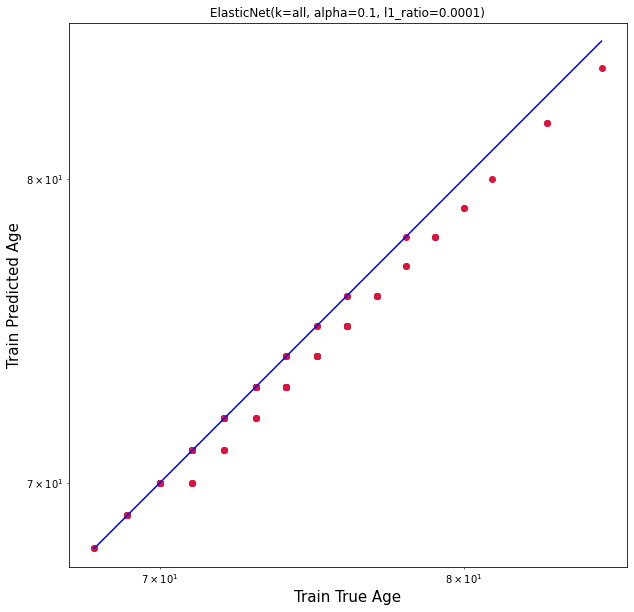

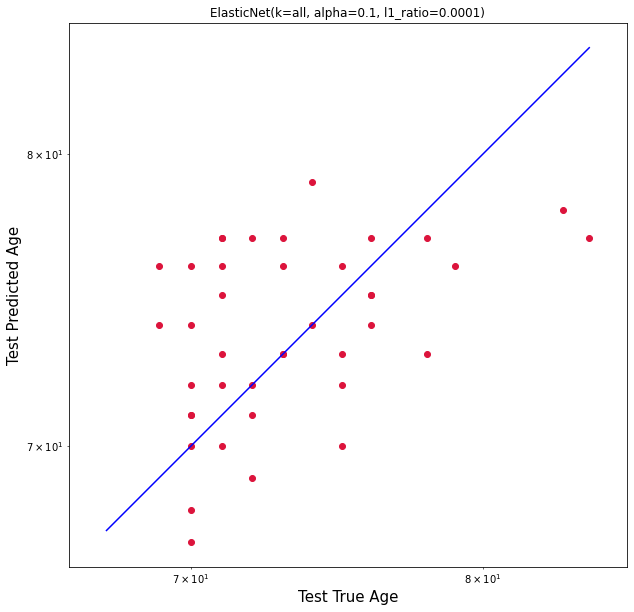

In [15]:
print(poly_x.shape)

elastic_best = search_elastic.best_estimator_

# Predict age
predict_train = elastic_best.predict(x_train)
predict_test = elastic_best.predict(x_test)

# Compute error
train_error = predict_train - y_train
test_error = predict_test - y_test

train_score = mean_absolute_error(y_train, predict_train)
test_score = mean_absolute_error(y_test, predict_test)

print(f'[k={elastic_best.steps[0][1].get_params()["k"]}, alpha={elastic_best.steps[1][1].get_params()["alpha"]}, l1_ratio={elastic_best.steps[1][1].get_params()["l1_ratio"]}] train_score: {train_score}')
print(f'[k={elastic_best.steps[0][1].get_params()["k"]}, alpha={elastic_best.steps[1][1].get_params()["alpha"]}, l1_ratio={elastic_best.steps[1][1].get_params()["l1_ratio"]}] test_score: {test_score}')

plot_results(y_train, y_test, predict_train, predict_test, {
    'k': elastic_best.steps[0][1].get_params()["k"],
    'alpha': elastic_best.steps[1][1].get_params()["alpha"],
    'l1_ratio': elastic_best.steps[1][1].get_params()["l1_ratio"]
}, 'ElasticNet')

# Random Forest

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## Grid Search - Polynomial Features

In [ ]:
poly = PolynomialFeatures(2)
poly_x = poly.fit_transform(x)
#poly_x = x

x_train, x_test, y_train, y_test = train_test_split(poly_x, y, test_size=0.3, random_state=42)

# Define pipeline
forest_pipe = Pipeline(steps=[
    ('select', SelectKBest(f_regression, k=10)),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid = {
    'select__k': [10, 50, 100, 200, 'all'],
    'regressor__max_depth': [5, 10, 15]
}
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

random_forest_search = GridSearchCV(forest_pipe, grid, cv=cv, n_jobs=1, verbose=10, scoring='neg_mean_absolute_error')
random_forest_search.fit(x_train, y_train)

In [ ]:
print(random_forest_search.best_estimator_)
print(random_forest_search.best_score_)

In [ ]:
print(poly_x.shape)
random_forest_best = random_forest_search.best_estimator_

# Predict age
predict_train = random_forest_best.predict(x_train)
predict_test = random_forest_best.predict(x_test)

# Compute error
train_error = predict_train - y_train
test_error = predict_test - y_test

train_score = mean_absolute_error(y_train, predict_train)
test_score = mean_absolute_error(y_test, predict_test)

print(f'train_score: {train_score}')
print(f'test_score: {test_score}')

plot_results(y_train, y_test, predict_train, predict_test, {
    'k': random_forest_best.steps[0][1].get_params()["k"],
    'max_depth': random_forest_best.steps[1][1].get_params()["max_depth"]
}, 'RandomForest')